Data Dictionary
Variable Name Description:

- Item_Identifier: Unique product ID
- Item_Weight: Weight of product
- Item_Fat_Content: Whether the product is low fat or regular
- Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product
- Item_Type: The category to which the product belongs
- Item_MRP: Maximum Retail Price (list price) of the product
- Outlet_Identifier: Unique store ID
- Outlet_Establishment_Year: The year in which store was established
- Outlet_Size: The size of the store in terms of ground area covered
- Outlet_Location_Type: The type of area in which the store is located
- Outlet_Type: Whether the outlet is a grocery store or some sort of supermarket
- Item_Outlet_Sales: Sales of the product in the particular store. This is the target variable to be predicted.

# Import

In [1]:
#Import
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
set_config(display='diagram')

filename = "Data/sales_predictions.csv"
df = pd.read_csv(filename)


# Functions

In [2]:
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')
  

In [3]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [4]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances



In [5]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [6]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs



In [7]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax



In [8]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax


# Checking Versions

In [9]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


# Data Cleaning

How many Rows and Columns?

In [10]:
rows = len(df)
columns = len(df.columns)
print(f"There are {rows} rows and {columns} columns.")

There are 8523 rows and 12 columns.


-- or

In [11]:
df.shape

(8523, 12)

In [12]:
print(f"The datatype for rows is {type(rows)} and for columns it's {type(columns)}")

The datatype for rows is <class 'int'> and for columns it's <class 'int'>


-- Or

In [13]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

**Duplicates?**

- No duplicates no worries

In [14]:
df.duplicated().sum()

0

**Missing values?**

In [15]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

**Dropping Item_Identifier and Outlet_Identifier**

- Dropping the Outlet_Identifier because this particular data does not contribute to the sales predicitons, it's irrelevant to the items being sold.

- Then checking for removal of column with df.drop()

In [16]:
df = df.drop(columns= ["Outlet_Identifier", "Item_Identifier"])

df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
#Sucess!
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Filling Missing Data

- Checking for missing values.
- Then filling data for missing values and confirming change.

In [18]:
print(df.isna().sum())

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [19]:
mean_item_weight = df['Item_Weight'].mean()
df['Item_Weight'].fillna(mean_item_weight, inplace = True)
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [20]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Summary Statistics**

In [21]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Exploratory Visuals

In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


C:\Users\caill\AppData\Local\Temp\ipykernel_27956\1528130796.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


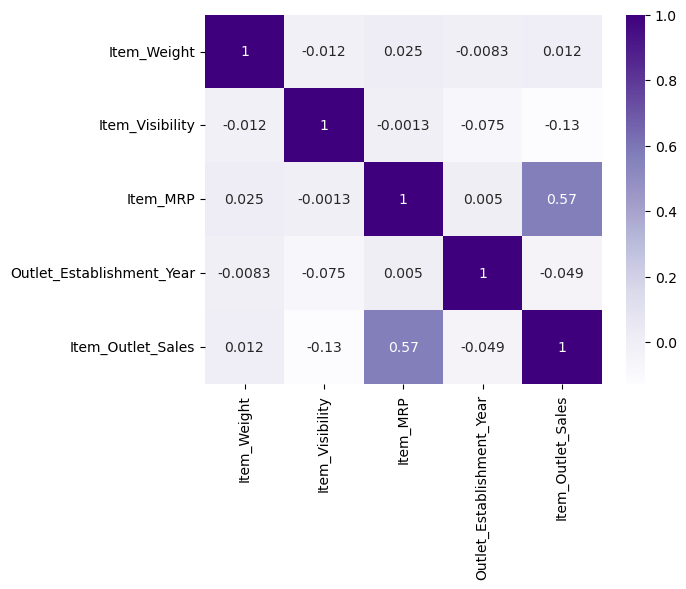

In [23]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Purples', annot = True)
plt.show()

- Checking to see which data has a positive or negative correlation.

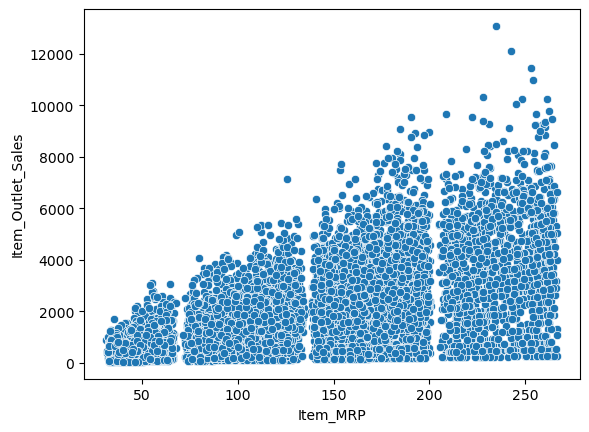

In [24]:
sns.scatterplot(data = df, x = "Item_MRP" , y = "Item_Outlet_Sales")
plt.show()

- This scatterplot shows a positive correlation between Item Outlet Sales and MRP (Highest list price). This means the higher the list price the higher the sale of that item.


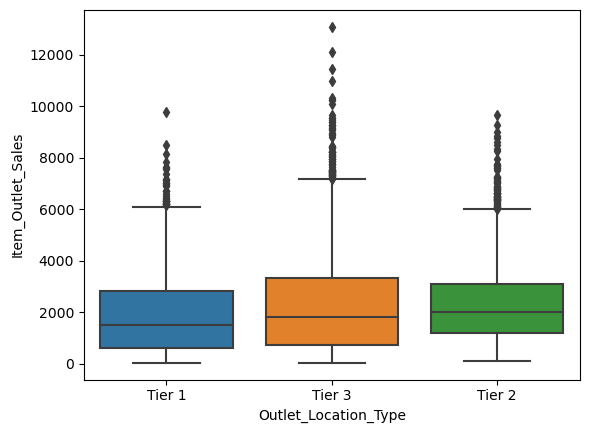

In [25]:
sns.boxplot(data = df, x = "Outlet_Location_Type", y = "Item_Outlet_Sales")
plt.show()

- The average sales are slightly made more at Tier 2 areas than the others. However there are many outliers above the max in all tiers to suggest otherwise.

# Explanatory Visuals

**Checking for styles**

In [26]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

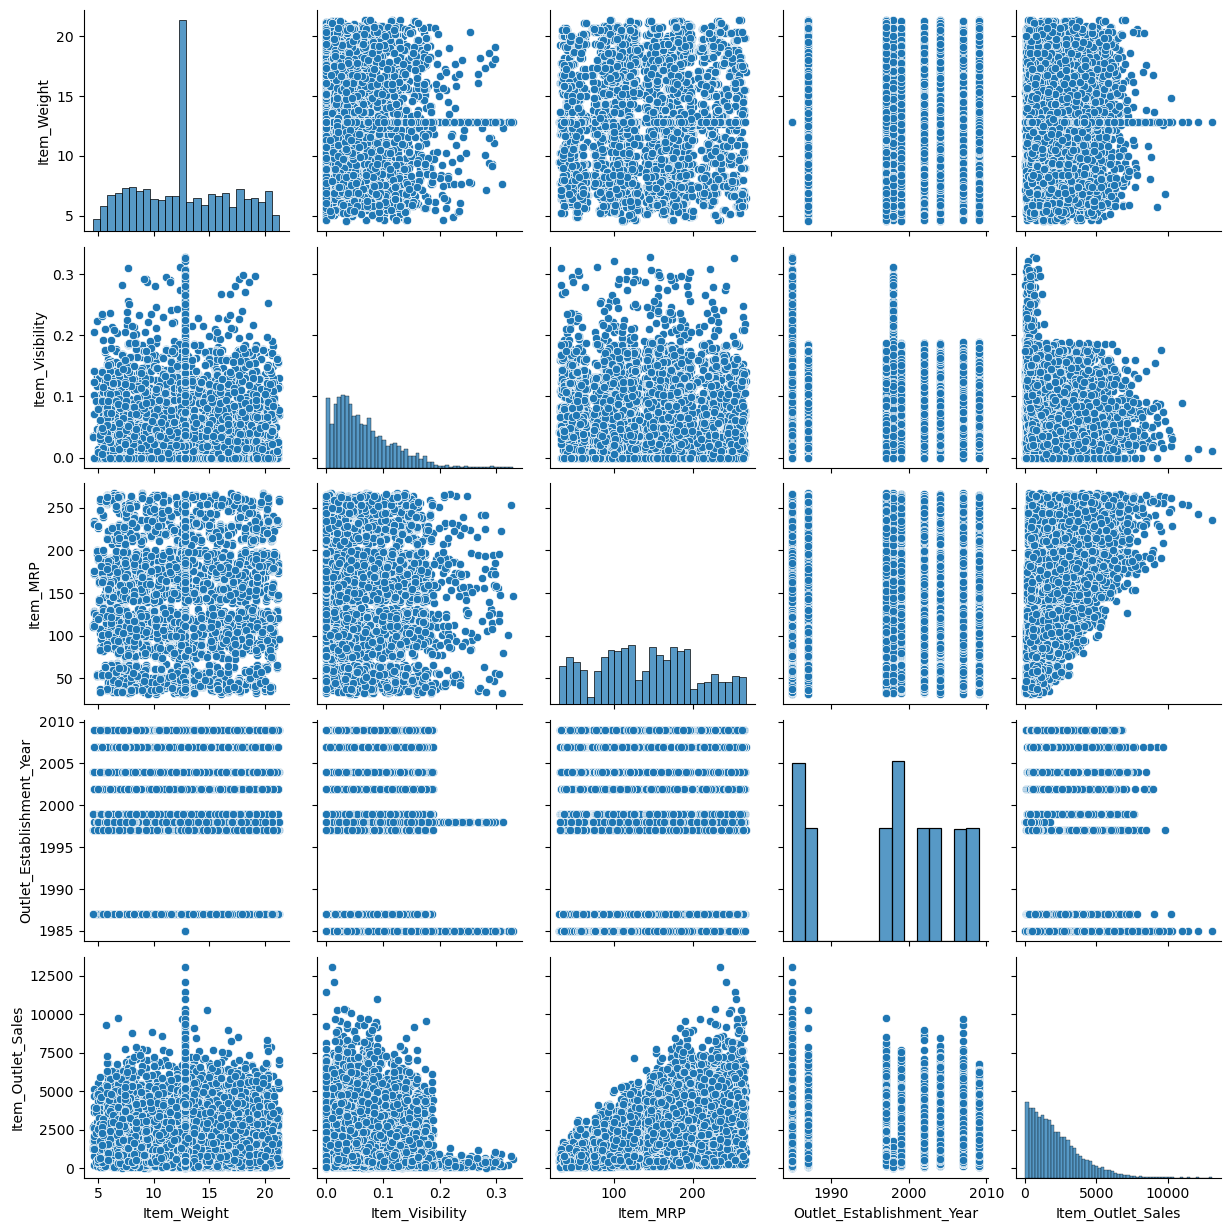

In [27]:
#checking for trends
sns.pairplot(df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


- Where have sales been since the start of the busines and what should be done to keep them at a steady rate?

In [29]:
plt.style.use("seaborn-darkgrid")

C:\Users\caill\AppData\Local\Temp\ipykernel_27956\1120890811.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


C:\Users\caill\AppData\Local\Temp\ipykernel_27956\3138454457.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = df, y ="Item_Outlet_Sales", x = "Outlet_Establishment_Year", ci = None, marker ="o")


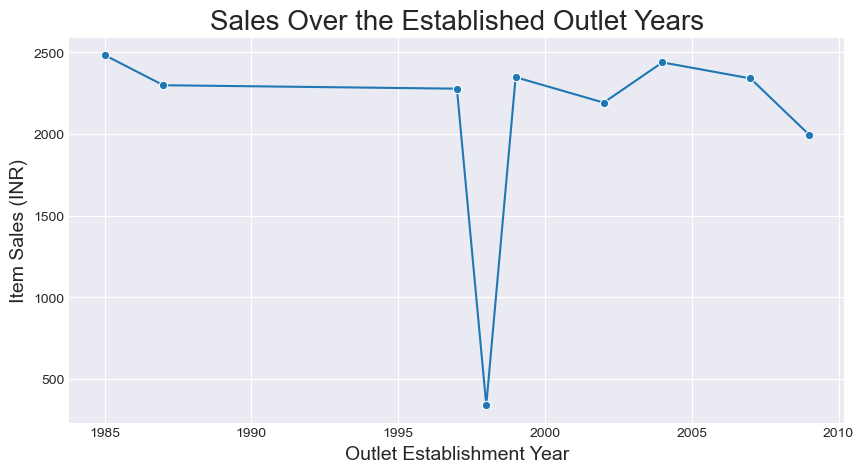

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data = df, y ="Item_Outlet_Sales", x = "Outlet_Establishment_Year", ci = None, marker ="o")
plt.xlabel("Outlet Establishment Year", fontsize = 14)
plt.ylabel("Item Sales (INR)", fontsize = 14)
plt.title("Sales Over the Established Outlet Years", fontsize = 20);
plt.show()

Data shows that sales have been fairly steady since 1985 but took a big dip in sales between 1995-2000. Afterwards data shows that sales shot back up and have been a bit rocky since then. 

Reccomendation : Find out why sales were shot down in between 1995-2000's and what was done differently to bring them back up. Recreate that situation and you may be able to keep sales steady again.

- Will people buy more of a product if it's cheaper?

C:\Users\caill\AppData\Local\Temp\ipykernel_27956\2152905913.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


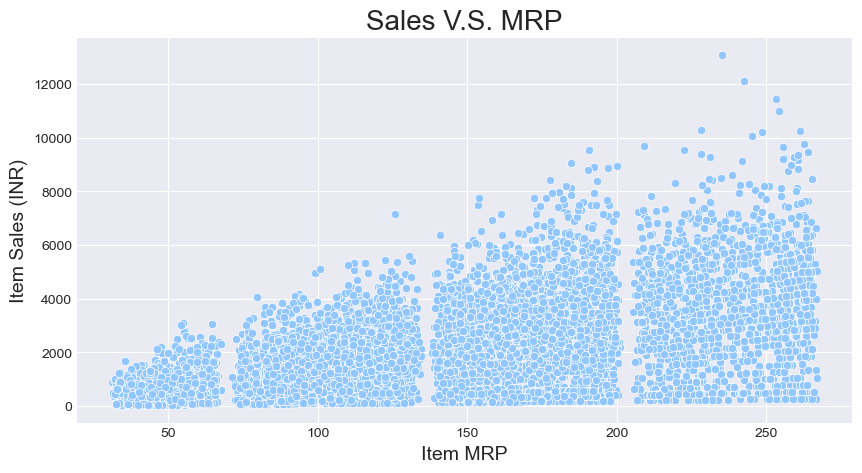

In [31]:
plt.style.use("seaborn-pastel")
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df, x ="Item_MRP", y = "Item_Outlet_Sales")
plt.title("Sales V.S. MRP", fontsize = 20)
plt.xlabel("Item MRP", fontsize = 14)
plt.ylabel("Item Sales (INR)", fontsize = 14)
plt.show()

The data shows more sales occur when the price of the item is higher.

Reccomendation: Make products that are not selling, higher in value. This may spark a change in sales.

# Machine Learning

In [32]:
#Define X and y
X = df.drop(columns = ["Item_Outlet_Sales"]).copy()

y = df["Item_Outlet_Sales"].copy()


#Train test split the data to prepare for machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.isna().any()


Item_Weight                  False
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
dtype: bool

In [33]:
df["Outlet_Size"].dropna(inplace = True)

In [34]:
#Create a ColumnTransformer to preprocess the data
cat_selector = make_column_selector(dtype_include = "object")
num_selector = make_column_selector(dtype_include ="number")

cat_selector(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [35]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

In [36]:
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [37]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [38]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [39]:
# create tuples of (imputer, selector) for each datatype
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)
# instantiate ColumnTransformer (processor)
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019EFCE895E0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019EFB2FC0D0>)])

In [40]:
#Transform your data and display the result.
col_transformer.fit(X_train)
X_train_imputed = col_transformer.transform(X_train)
X_test_imputed = col_transformer.transform(X_test)
# change the result back to a dataframe to find any missing data
#X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
#X_train_imputed.isna().any()

### Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

from sklearn.pipeline import make_pipeline
reg_pipe = make_pipeline(scaler, reg)


In [42]:
#fit on imputed data (other data has null possibly)
reg_pipe.fit(X_train_imputed,y_train)

pred_test = reg_pipe.predict(X_test_imputed)
pred_train = reg_pipe.predict(X_train_imputed)

model_metrics(reg_pipe, X_train_imputed, y_train, X_test_imputed, y_test, model_name='Decision Regression')


Decision Regression Train Scores
MAE: 847.1957 
MSE: 1,298,632.5296 
RMSE: 1,139.5756 
R2: 0.5612

Decision Regression Test Scores
MAE: 803.9930 
MSE: 1,194,497.5596 
RMSE: 1,092.9307 
R2: 0.5671



In [43]:
###Regression Tree

dec_tree = DecisionTreeRegressor(random_state = 42)

dec_tree.fit(X_train_imputed, y_train)

train_preds = dec_tree.predict(X_train_imputed)
test_preds = dec_tree.predict(X_test_imputed)

In [44]:
# evaluating the model
train_score = dec_tree.score(X_train_imputed, y_train)
test_score = dec_tree.score(X_test_imputed, y_test)
print(train_score)
print(test_score)

1.0
0.18054765703238174


There seems to be an issue of overfitting in the decision tree. The R2 score in the training is higher than the testing data.

In [45]:
print(dec_tree.get_depth())

40


In [46]:
print(dec_tree.get_n_leaves())

6265


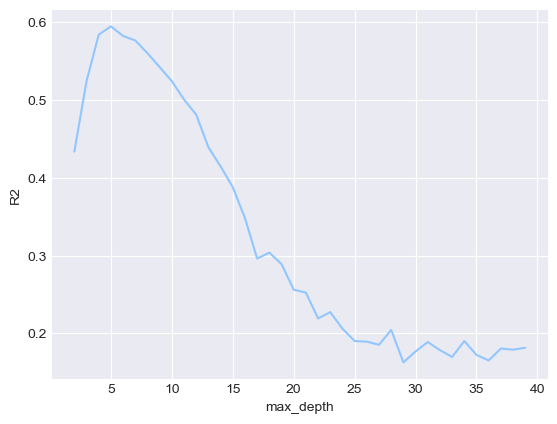

In [47]:
depths = list(range(2, 40)) # will try every value between 2 and 40

scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_imputed, y_train)
    train_score = dec_tree.score(X_train_imputed, y_train)
    test_score = dec_tree.score(X_test_imputed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [48]:
#Looking at wich depth precisely has the highest r2 test score
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.59471,0.60394
4,0.584005,0.582625
6,0.582356,0.615072
7,0.576592,0.626454
8,0.560262,0.642714


In [49]:
#Using index with highest test score
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_imputed, y_train)
train_5_score = dec_tree_5.score(X_train_imputed, y_train)
test_5_score = dec_tree_5.score(X_test_imputed, y_test)
print(train_5_score)
print(test_5_score)
#Happy balance~

0.6039397477322956
0.5947099753159972


In [50]:
#R2 and RMSE Score for regression tree
model_metrics(dec_tree_5, X_train_imputed, y_train, X_test_imputed, y_test, model_name='Decision Regression')

Decision Regression Train Scores
MAE: 762.6102 
MSE: 1,172,122.7729 
RMSE: 1,082.6462 
R2: 0.6039

Decision Regression Test Scores
MAE: 738.3173 
MSE: 1,118,185.9731 
RMSE: 1,057.4431 
R2: 0.5947



The data fits better on the regression tree than the linear model and there are less penalized errors on the regression tree.

### Recommendation of which model to use

I recommend using the decision regression tree. The regression tree will be the best model to use due to the better fit and fewer errors.

# Linear Regression Feature Importance (Unscaled)

In [51]:
## Make x and y variables
X = df.drop(columns = ["Item_Outlet_Sales"]).copy()

y = df["Item_Outlet_Sales"].copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,2002,NaN,Tier 2,Supermarket Type1


In [52]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [53]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [54]:
## make pipelines for categorical vs numeric data w/o scaling
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent', fill_value='MISSING'),
                         OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))



In [55]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019EF5E2C9D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019EF5E2CA00>)],
                  verbose_feature_names_out=False)

In [56]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Regular',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_Medium',
       'Outlet_Size_Small', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [57]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.35,0.029565,256.4646,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7510,15.25,0.000000,179.7660,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,12.35,0.158716,157.2946,1999.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [58]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.026300,79.4302,1987.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2957,7.93,0.071136,42.7086,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7031,14.50,0.041313,42.0454,1999.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

7503    1743.0644
2957     356.8688
7031     377.5086
Name: Item_Outlet_Sales, dtype: float64

In [60]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)


Training Data:	R^2= 0.56	RMSE= 1139.58
Test Data:	R^2= 0.57	RMSE= 1092.93


In [61]:
#Checking options
df.select_dtypes('object').nunique()

Item_Fat_Content         2
Item_Type               16
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In [62]:
lin_reg.coef_

array([-1.86996365e+00, -4.23333708e+02,  1.57230000e+01,  3.45285301e+01,
        6.19603607e+01, -2.35724010e+01,  4.72361981e+01,  2.89271813e+01,
       -1.05311316e+02, -1.98696500e+00,  4.79127440e+01,  1.82825876e+01,
        2.74640429e+01,  5.76801945e+00, -9.85702667e+00, -2.82300899e+01,
        3.29234586e+02, -1.94871690e+01, -3.88365265e+01,  4.62313285e+01,
       -8.61328312e+02, -7.98679685e+02, -1.97345282e+02, -4.17308538e+02,
        1.51148490e+03,  1.27818149e+03,  3.81474408e+03])

In [63]:
## Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

27


27

In [64]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                           -1.869964
Item_Visibility                     -423.333708
Item_MRP                              15.723000
Outlet_Establishment_Year             34.528530
Item_Fat_Content_Regular              61.960361
Item_Type_Breads                     -23.572401
Item_Type_Breakfast                   47.236198
Item_Type_Canned                      28.927181
Item_Type_Dairy                     -105.311316
Item_Type_Frozen Foods                -1.986965
Item_Type_Fruits and Vegetables       47.912744
Item_Type_Hard Drinks                 18.282588
Item_Type_Health and Hygiene          27.464043
Item_Type_Household                    5.768019
Item_Type_Meat                        -9.857027
Item_Type_Others                     -28.230090
Item_Type_Seafood                    329.234586
Item_Type_Snack Foods                -19.487169
Item_Type_Soft Drinks                -38.836527
Item_Type_Starchy Foods               46.231328
Outlet_Size_Medium                  -861

In [65]:
coeffs.sum()

-65211.67856863287

In [66]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

intercept                          28.0
Outlet_Type_Supermarket Type3      27.0
Outlet_Type_Supermarket Type1      26.0
Outlet_Type_Supermarket Type2      25.0
Outlet_Size_Medium                 24.0
Outlet_Size_Small                  23.0
Item_Visibility                    22.0
Outlet_Location_Type_Tier 3        21.0
Item_Type_Seafood                  20.0
Outlet_Location_Type_Tier 2        19.0
Item_Type_Dairy                    18.0
Item_Fat_Content_Regular           17.0
Item_Type_Fruits and Vegetables    16.0
Item_Type_Breakfast                15.0
Item_Type_Starchy Foods            14.0
Item_Type_Soft Drinks              13.0
Outlet_Establishment_Year          12.0
Item_Type_Canned                   11.0
Item_Type_Others                   10.0
Item_Type_Health and Hygiene        9.0
Item_Type_Breads                    8.0
Item_Type_Snack Foods               7.0
Item_Type_Hard Drinks               6.0
Item_MRP                            5.0
Item_Type_Meat                      4.0


In [67]:
top_n_features = coeff_rank.head(10)
top_n_features

intercept                        28.0
Outlet_Type_Supermarket Type3    27.0
Outlet_Type_Supermarket Type1    26.0
Outlet_Type_Supermarket Type2    25.0
Outlet_Size_Medium               24.0
Outlet_Size_Small                23.0
Item_Visibility                  22.0
Outlet_Location_Type_Tier 3      21.0
Item_Type_Seafood                20.0
Outlet_Location_Type_Tier 2      19.0
dtype: float64

In [68]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

Item_Weight                            -1.87
Item_Visibility                      -423.33
Item_MRP                               15.72
Outlet_Establishment_Year              34.53
Item_Fat_Content_Regular               61.96
Item_Type_Breads                      -23.57
Item_Type_Breakfast                    47.24
Item_Type_Canned                       28.93
Item_Type_Dairy                      -105.31
Item_Type_Frozen Foods                 -1.99
Item_Type_Fruits and Vegetables        47.91
Item_Type_Hard Drinks                  18.28
Item_Type_Health and Hygiene           27.46
Item_Type_Household                     5.77
Item_Type_Meat                         -9.86
Item_Type_Others                      -28.23
Item_Type_Seafood                     329.23
Item_Type_Snack Foods                 -19.49
Item_Type_Soft Drinks                 -38.84
Item_Type_Starchy Foods                46.23
Outlet_Size_Medium                   -861.33
Outlet_Size_Small                    -798.68
Outlet_Loc

In [69]:
## Slicing out the top_n_features names to visualize
plot_vals = coeffs.loc[top_n_features.index]
plot_vals.head(4)

intercept                       -69,552.21
Outlet_Type_Supermarket Type3     3,814.74
Outlet_Type_Supermarket Type1     1,511.48
Outlet_Type_Supermarket Type2     1,278.18
dtype: float64

- Outlet_Type_Supermarket Type 3 is the most important to the target but Type 1 & 2 are also almost equally important.

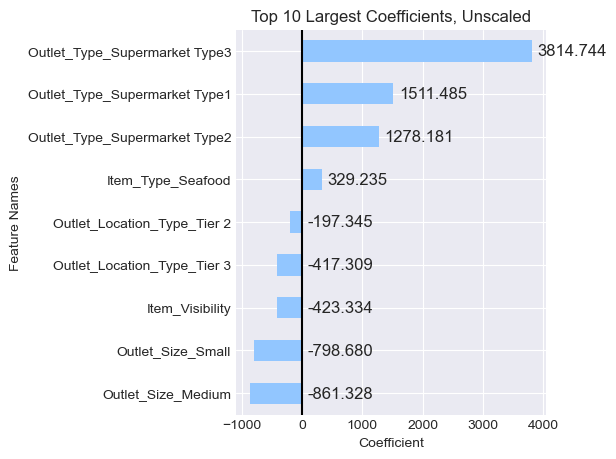

In [70]:
ax = plot_coeffs(plot_vals,top_n=10, annotate=True);
ax.set_title('Top 10 Largest Coefficients, Unscaled');
fig_gcf = plt.gcf()

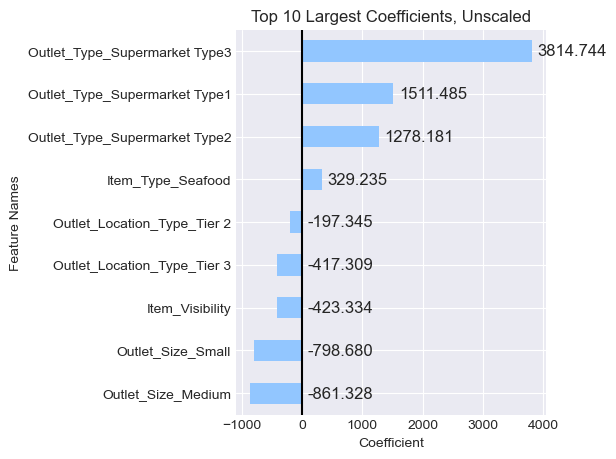

In [71]:
fig_gcf

- Intercept: Our model assumed a baseline score of -69,552.21
- Unscaled:
   - Positive:
   - Outlet_Type_Supermarket:
      - Type 3: This coefficient tells us that adding a Type 3 supermarket increases sales by $3,814.74.
      
      - Type 1: Adding a Type 1 supermarket increases sales by $1,511.49.
           
     - Type 2: Adding a Type 2 supermarket increases sales by $1,278.18.

## Scaled

In [72]:
## Make x and y variables
X = df.drop(columns = ["Item_Outlet_Sales"]).copy()

y = df["Item_Outlet_Sales"].copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.03,Household,256.46,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.00,Snack Foods,179.77,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.16,Meat,157.29,1999,Medium,Tier 1,Supermarket Type1
5327,7.97,Low Fat,0.01,Baking Goods,82.33,2004,Small,Tier 2,Supermarket Type1
4810,19.35,Low Fat,0.02,Frozen Foods,120.91,2002,NaN,Tier 2,Supermarket Type1


In [73]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.33,-0.78,-1.00,-1.29,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
2957,-1.18,0.10,-1.59,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
7031,0.38,-0.48,-1.60,0.14,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [74]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

7503   1,743.06
2957     356.87
7031     377.51
Name: Item_Outlet_Sales, dtype: float64

In [75]:
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)


Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


In [76]:
#Checking options
df.select_dtypes('object').nunique()

Item_Fat_Content         2
Item_Type               16
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In [77]:
lin_reg.coef_

array([-8.18682451e+00, -2.16464734e+01,  9.84513074e+02,  2.37564740e+02,
        6.26252336e+01, -2.86483181e+01,  4.53610637e+01,  2.75161942e+01,
       -1.06335014e+02, -1.77062620e+00,  4.57540295e+01,  1.38948991e+01,
        2.70254137e+01,  5.50974637e+00, -1.18648866e+01, -2.68137258e+01,
        3.27501136e+02, -2.19323926e+01, -3.94857352e+01,  4.20888647e+01,
       -7.70100331e+02, -5.79159249e+02, -6.34056295e+02, -5.11715849e+01,
       -2.62991308e+02,  1.53434995e+03,  1.15568474e+03,  3.54302552e+03])

In [78]:
## Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

28


28

In [79]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                          -8.19
Item_Visibility                     -21.65
Item_MRP                            984.51
Outlet_Establishment_Year           237.56
Item_Fat_Content_Regular             62.63
Item_Type_Breads                    -28.65
Item_Type_Breakfast                  45.36
Item_Type_Canned                     27.52
Item_Type_Dairy                    -106.34
Item_Type_Frozen Foods               -1.77
Item_Type_Fruits and Vegetables      45.75
Item_Type_Hard Drinks                13.89
Item_Type_Health and Hygiene         27.03
Item_Type_Household                   5.51
Item_Type_Meat                      -11.86
Item_Type_Others                    -26.81
Item_Type_Seafood                   327.50
Item_Type_Snack Foods               -21.93
Item_Type_Soft Drinks               -39.49
Item_Type_Starchy Foods              42.09
Outlet_Size_MISSING                -770.10
Outlet_Size_Medium                 -579.16
Outlet_Size_Small                  -634.06
Outlet_Loca

In [80]:
coeffs.sum()

6855.846727849469

In [81]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

Outlet_Type_Supermarket Type3     29.00
Outlet_Type_Supermarket Type1     28.00
intercept                         27.00
Outlet_Type_Supermarket Type2     26.00
Item_MRP                          25.00
Outlet_Size_MISSING               24.00
Outlet_Size_Small                 23.00
Outlet_Size_Medium                22.00
Item_Type_Seafood                 21.00
Outlet_Location_Type_Tier 3       20.00
Outlet_Establishment_Year         19.00
Item_Type_Dairy                   18.00
Item_Fat_Content_Regular          17.00
Outlet_Location_Type_Tier 2       16.00
Item_Type_Fruits and Vegetables   15.00
Item_Type_Breakfast               14.00
Item_Type_Starchy Foods           13.00
Item_Type_Soft Drinks             12.00
Item_Type_Breads                  11.00
Item_Type_Canned                  10.00
Item_Type_Health and Hygiene       9.00
Item_Type_Others                   8.00
Item_Type_Snack Foods              7.00
Item_Visibility                    6.00
Item_Type_Hard Drinks              5.00


In [82]:
top_n_features = coeff_rank.head(10)
top_n_features

Outlet_Type_Supermarket Type3   29.00
Outlet_Type_Supermarket Type1   28.00
intercept                       27.00
Outlet_Type_Supermarket Type2   26.00
Item_MRP                        25.00
Outlet_Size_MISSING             24.00
Outlet_Size_Small               23.00
Outlet_Size_Medium              22.00
Item_Type_Seafood               21.00
Outlet_Location_Type_Tier 3     20.00
dtype: float64

In [83]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

Item_Weight                          -8.19
Item_Visibility                     -21.65
Item_MRP                            984.51
Outlet_Establishment_Year           237.56
Item_Fat_Content_Regular             62.63
Item_Type_Breads                    -28.65
Item_Type_Breakfast                  45.36
Item_Type_Canned                     27.52
Item_Type_Dairy                    -106.34
Item_Type_Frozen Foods               -1.77
Item_Type_Fruits and Vegetables      45.75
Item_Type_Hard Drinks                13.89
Item_Type_Health and Hygiene         27.03
Item_Type_Household                   5.51
Item_Type_Meat                      -11.86
Item_Type_Others                    -26.81
Item_Type_Seafood                   327.50
Item_Type_Snack Foods               -21.93
Item_Type_Soft Drinks               -39.49
Item_Type_Starchy Foods              42.09
Outlet_Size_MISSING                -770.10
Outlet_Size_Medium                 -579.16
Outlet_Size_Small                  -634.06
Outlet_Loca

In [84]:
## Slicing out the top_n_features names to visualize
plot_vals = coeffs.loc[top_n_features.index]
plot_vals.head(4)

Outlet_Type_Supermarket Type3   3,543.03
Outlet_Type_Supermarket Type1   1,534.35
intercept                       1,367.59
Outlet_Type_Supermarket Type2   1,155.68
dtype: float64

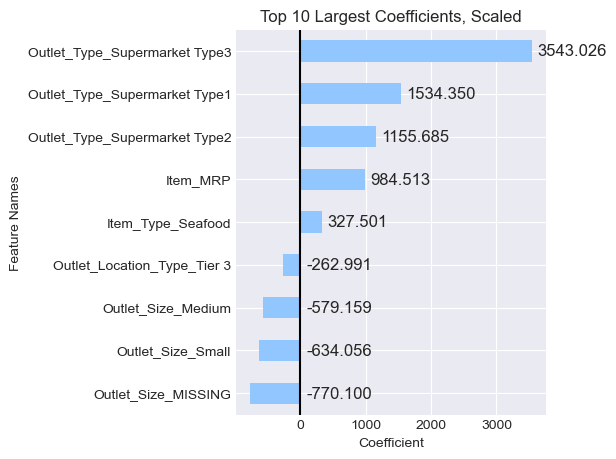

In [85]:
ax = plot_coeffs(plot_vals,top_n=10, annotate=True);
ax.set_title('Top 10 Largest Coefficients, Scaled');
fig_gcf2 = plt.gcf()

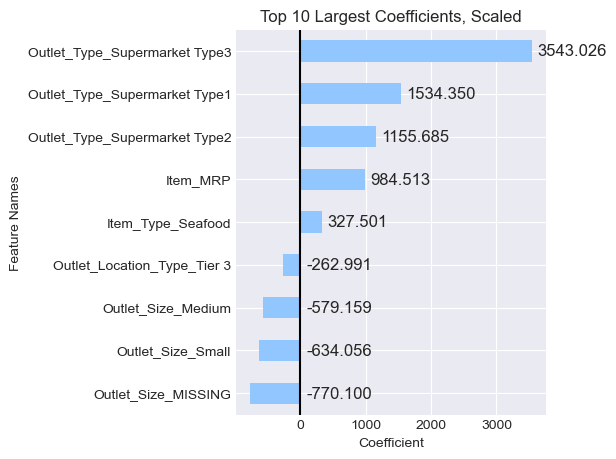

In [86]:
fig_gcf2

- For the scaled data the most important are still Outlet_Type_Supermarket 3, 1, & 2. This model is putting most of its' weight on these three deciding factors, for predicting the target. 

- The new baseline of the intercept is 1,367.59.

# Regression Model Feature Importance (Unscaled)

In [87]:
## Make x and y variables
X = df.drop(columns = ["Item_Outlet_Sales"]).copy()

y = df["Item_Outlet_Sales"].copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.03,Household,256.46,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.00,Snack Foods,179.77,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.16,Meat,157.29,1999,Medium,Tier 1,Supermarket Type1
5327,7.97,Low Fat,0.01,Baking Goods,82.33,2004,Small,Tier 2,Supermarket Type1
4810,19.35,Low Fat,0.02,Frozen Foods,120.91,2002,NaN,Tier 2,Supermarket Type1


In [88]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.03,79.43,"1,987.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2957,7.93,0.07,42.71,"1,997.00",0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,14.50,0.04,42.05,"1,999.00",1.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [89]:
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 429.74
Test Data:	R^2= 0.55	RMSE= 1112.73


In [90]:
reg.feature_importances_

array([0.05246667, 0.10098446, 0.44394224, 0.03847791, 0.00878723,
       0.00406975, 0.00264263, 0.00265289, 0.00452352, 0.00622766,
       0.00559877, 0.00808534, 0.0031141 , 0.00417171, 0.00656893,
       0.00362791, 0.00157719, 0.00170797, 0.00825635, 0.00546745,
       0.00346006, 0.00251214, 0.00502287, 0.00424346, 0.00668257,
       0.0048065 , 0.00366899, 0.0032782 , 0.19172982, 0.0019205 ,
       0.00165385, 0.05807037])

In [91]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

32
32


True

In [92]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                       0.05
Item_Visibility                   0.10
Item_MRP                          0.44
Outlet_Establishment_Year         0.04
Item_Fat_Content_Regular          0.01
Item_Type_Baking Goods            0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Canned                  0.00
Item_Type_Dairy                   0.01
Item_Type_Frozen Foods            0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Hard Drinks             0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Household               0.01
Item_Type_Meat                    0.00
Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Snack Foods             0.01
Item_Type_Soft Drinks             0.01
Item_Type_Starchy Foods           0.00
Outlet_Size_High                  0.00
Outlet_Size_MISSING               0.01
Outlet_Size_Medium                0.00
Outlet_Size_Small                 0.01
Outlet_Location_Type_Tier

In [93]:
importances.sum()

1.0

In [94]:
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values(ascending=True)
sorted_importance

Item_Type_Others                  0.00
Outlet_Type_Supermarket Type2     0.00
Item_Type_Seafood                 0.00
Outlet_Type_Supermarket Type1     0.00
Outlet_Size_High                  0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Hard Drinks             0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Starchy Foods           0.00
Item_Type_Meat                    0.00
Outlet_Location_Type_Tier 2       0.00
Item_Type_Baking Goods            0.00
Item_Type_Health and Hygiene      0.00
Outlet_Size_Medium                0.00
Item_Type_Canned                  0.00
Outlet_Location_Type_Tier 1       0.00
Outlet_Size_MISSING               0.01
Item_Type_Soft Drinks             0.01
Item_Type_Frozen Foods            0.01
Item_Type_Dairy                   0.01
Item_Type_Household               0.01
Outlet_Size_Small                 0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Snack Foods             0.01
Item_Fat_Content_Regular 

- In this regression model Item_MRP seems to be the most important deciding factor.

In [95]:
importances.sort_values(ascending=False).head(5)

Item_MRP                        0.44
Outlet_Type_Grocery Store       0.19
Item_Visibility                 0.10
Outlet_Type_Supermarket Type3   0.06
Item_Weight                     0.05
Name: Feature Importance, dtype: float64

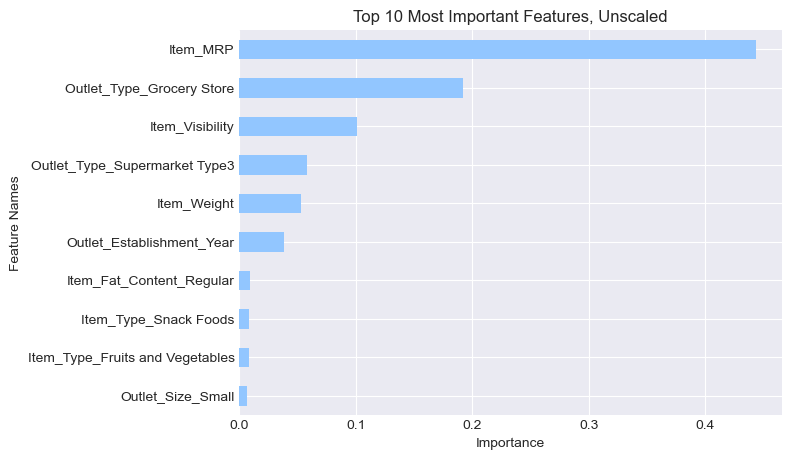

In [111]:
## plotting top 10 importances
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features, Unscaled');

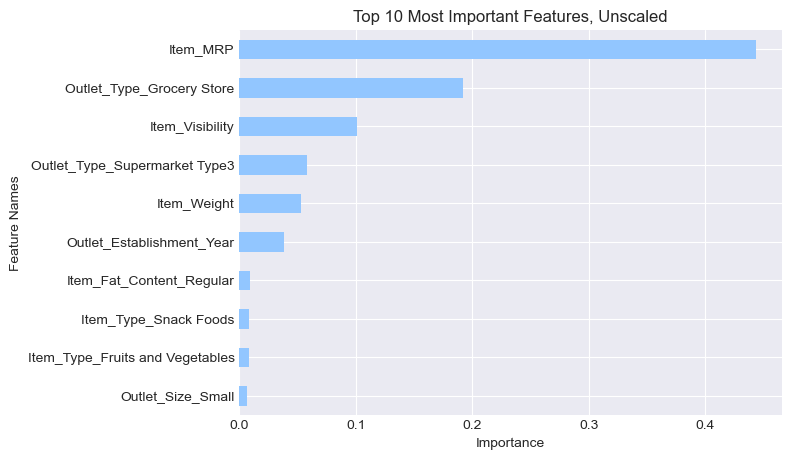

In [112]:
## using the ax to get the fig
fig_ax = ax.get_figure()
fig_ax

- This model shows that Item_MRP has the highest relationship with the target. The 2nd, 3rd, 4th, and 5th are Outlet_Type_Grocery Store, Item_Visibility, Outlet_Typer_Supermarket Type3, and Item_Weight.

## Scaled

In [113]:
## Make x and y variables
X = df.drop(columns = ["Item_Outlet_Sales"]).copy()

y = df["Item_Outlet_Sales"].copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.03,Household,256.46,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.00,Snack Foods,179.77,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.16,Meat,157.29,1999,Medium,Tier 1,Supermarket Type1
5327,7.97,Low Fat,0.01,Baking Goods,82.33,2004,Small,Tier 2,Supermarket Type1
4810,19.35,Low Fat,0.02,Frozen Foods,120.91,2002,NaN,Tier 2,Supermarket Type1


In [114]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.33,-0.78,-1.00,-1.29,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2957,-1.18,0.10,-1.59,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,0.38,-0.48,-1.60,0.14,1.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [115]:
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 429.85
Test Data:	R^2= 0.55	RMSE= 1112.67


In [116]:
reg.feature_importances_

array([0.05249446, 0.10097472, 0.44390941, 0.03847539, 0.00879436,
       0.00407001, 0.00264656, 0.00265274, 0.00452879, 0.0062333 ,
       0.00560421, 0.00808789, 0.00311238, 0.00417628, 0.00656852,
       0.00361875, 0.00157711, 0.00170837, 0.0082581 , 0.00547637,
       0.00345601, 0.00251253, 0.0050112 , 0.00423463, 0.00668431,
       0.00480198, 0.00367373, 0.00326645, 0.19172982, 0.00191281,
       0.00167843, 0.05807037])

In [117]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

32
32


True

In [118]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                       0.05
Item_Visibility                   0.10
Item_MRP                          0.44
Outlet_Establishment_Year         0.04
Item_Fat_Content_Regular          0.01
Item_Type_Baking Goods            0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Canned                  0.00
Item_Type_Dairy                   0.01
Item_Type_Frozen Foods            0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Hard Drinks             0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Household               0.01
Item_Type_Meat                    0.00
Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Snack Foods             0.01
Item_Type_Soft Drinks             0.01
Item_Type_Starchy Foods           0.00
Outlet_Size_High                  0.00
Outlet_Size_MISSING               0.01
Outlet_Size_Medium                0.00
Outlet_Size_Small                 0.01
Outlet_Location_Type_Tier

In [119]:
importances.sum()

1.0

In [120]:
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values(ascending=True)
sorted_importance

Item_Type_Others                  0.00
Outlet_Type_Supermarket Type2     0.00
Item_Type_Seafood                 0.00
Outlet_Type_Supermarket Type1     0.00
Outlet_Size_High                  0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Hard Drinks             0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Starchy Foods           0.00
Item_Type_Meat                    0.00
Outlet_Location_Type_Tier 2       0.00
Item_Type_Baking Goods            0.00
Item_Type_Health and Hygiene      0.00
Outlet_Size_Medium                0.00
Item_Type_Canned                  0.00
Outlet_Location_Type_Tier 1       0.00
Outlet_Size_MISSING               0.01
Item_Type_Soft Drinks             0.01
Item_Type_Frozen Foods            0.01
Item_Type_Dairy                   0.01
Item_Type_Household               0.01
Outlet_Size_Small                 0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Snack Foods             0.01
Item_Fat_Content_Regular 

In [121]:
importances.sort_values(ascending=False).head(5)

Item_MRP                        0.44
Outlet_Type_Grocery Store       0.19
Item_Visibility                 0.10
Outlet_Type_Supermarket Type3   0.06
Item_Weight                     0.05
Name: Feature Importance, dtype: float64

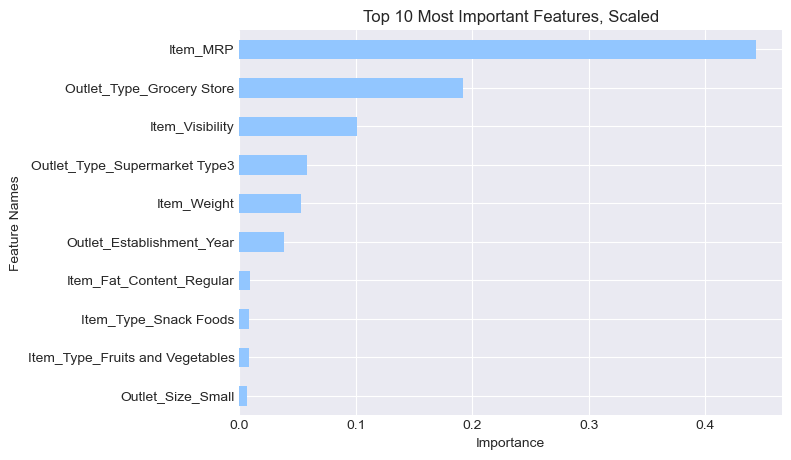

In [122]:
## plotting top 10 importances
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features, Scaled');


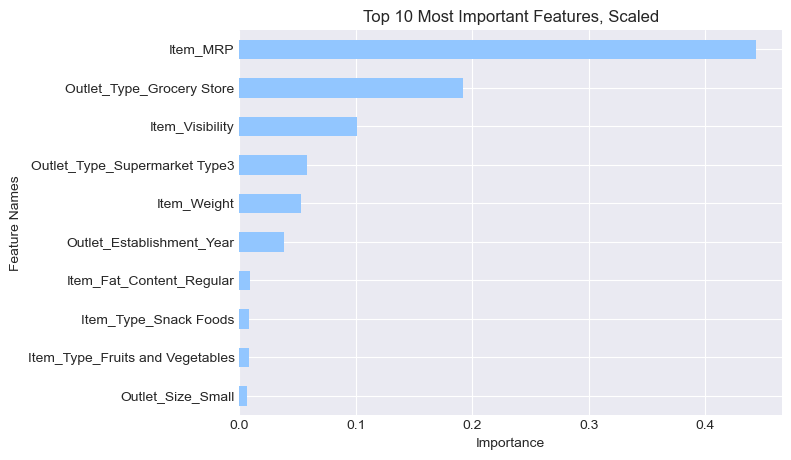

In [123]:
## using the ax to get the fig
fig_ax2 = ax.get_figure()
fig_ax2

- Scaled, the 5 most important features stayed the same with Item_MRP still having the highest importance. But, the order of the other features have changed.

In [124]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
          'LinearRegression':lin_reg,
         'RandomForestRegressor':reg}
joblib.dump(export, 'models.joblib')



['models.joblib']